In [21]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report

<h3>Load Data</h3>

In [2]:
fraud_df = pd.read_csv("../Collection of DS take home challenges/data collection-Product dataset数据挑战数据集/ML Identifying Fraudulent Activities with solution/Fraud_Data.csv")
ipaddress_df = pd.read_csv("../Collection of DS take home challenges/data collection-Product dataset数据挑战数据集/ML Identifying Fraudulent Activities with solution/IpAddress_to_Country.csv")

In [3]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ipaddress_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [6]:
ipaddress_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [12]:
countries = []
for i in range(len(fraud_df)):
    country = ipaddress_df[(ipaddress_df["lower_bound_ip_address"] <= fraud_df["ip_address"][i]) & (ipaddress_df["upper_bound_ip_address"] >= fraud_df["ip_address"][i])]["country"].values
    if len(country) == 1:
        countries.append(country[0])
    else:
        countries.append("NA")

In [14]:
fraud_df["country"] = countries

In [15]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [16]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [19]:
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"])
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])

In [21]:
fraud_df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

In [22]:
columns = ["source", "browser", "country"]
for i in columns:
    uniques = sorted(fraud_df[i].unique())
    print("{0:10s} {1:10d}\t".format(i, len(uniques)), uniques[:5])

source              3	 ['Ads', 'Direct', 'SEO']
browser             5	 ['Chrome', 'FireFox', 'IE', 'Opera', 'Safari']
country           182	 ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda']


<h3>Feature Engineering</h3>

In [23]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [48]:
# time interval
def time_interval(x):
    if x.hour >= 6 and x.hour <= 12:
        return("Morning")
    elif x.hour > 12 and x.hour <= 16:
        return("Afternoon")
    elif x.hour > 16 and x.hour <= 23:
        return("Evening/Night")
    elif x.hour >= 0 and x.hour < 6:
        return("Midnight")

In [49]:
fraud_df["signup_interval"] = fraud_df["signup_time"].apply(time_interval)
fraud_df["purchase_interval"] = fraud_df["purchase_time"].apply(time_interval)

In [69]:
# signup and purchase diff
fraud_df["difference"] = fraud_df["purchase_time"]-fraud_df["signup_time"]
fraud_df["difference"] = fraud_df["difference"].apply(lambda x: x.seconds)

In [84]:
# how many user_id associated with the device_id
fraud_df["num_user_id"] = fraud_df["device_id"].apply(lambda x: len(fraud_df[fraud_df["device_id"] == x]))
# lambda function is really slow, try to use merge next time

In [86]:
# how many user_id associated with the ip_address
ip_count = fraud_df.groupby("ip_address").size().reset_index().rename(columns = {0:"num_ip_address"})
fraud_df = fraud_df.merge(ip_count, how = "left", on = "ip_address")

In [88]:
# day of week
fraud_df["signup_day"] = fraud_df["signup_time"].apply(lambda x: x.strftime('%A'))
fraud_df["purchase_day"] = fraud_df["purchase_time"].apply(lambda x: x.strftime('%A'))

In [2]:
fraud_df = pd.read_csv("fraud_df.csv")

In [9]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_interval,purchase_interval,difference,num_user_id,num_ip_address,signup_day,purchase_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Evening/Night,Midnight,13882,1,1,Tuesday,Saturday
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,Evening/Night,Midnight,17944,1,1,Sunday,Monday
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,Evening/Night,Evening/Night,1,12,12,Thursday,Thursday
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,Evening/Night,Afternoon,60085,1,1,Tuesday,Monday
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,Morning,Evening/Night,41461,1,1,Tuesday,Wednesday


<h3>Model Building</h3>

In [10]:
# select features and target
df = fraud_df[["purchase_value", "source", "browser", "sex", "age", "country", "difference", "num_user_id", "num_ip_address", "signup_day", "purchase_day", "class"]]

In [7]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmpi5nk1858
  JVM stdout: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmpi5nk1858/h2o_haorzeng_started_from_python.out
  JVM stderr: /var/folders/45/cqp2n80x7xd2c9g9bjg9t2xr0000gn/T/tmpi5nk1858/h2o_haorzeng_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Indiana/Indianapolis
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,4 months and 20 days !!!
H2O_cluster_name:,H2O_from_python_haorzeng_gbt0qx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [11]:
h2o_df = H2OFrame(df)

for i in ["source", "browser", "sex", "country", "signup_day", "purchase_day", "class"]:
    h2o_df[i] = h2o_df[i].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
# train test split
strat_split = h2o_df["class"].stratified_split(test_frac= 0.3)
train = h2o_df[strat_split == "train"]
test = h2o_df[strat_split == "test"]

features = ["purchase_value", "source", "browser", "sex", "age", "country", "difference", "num_user_id", "num_ip_address", "signup_day", "purchase_day"]
target = "class"

In [14]:
clf = H2ORandomForestEstimator(balance_classes = True, stopping_rounds=5, stopping_metric='auc', score_each_iteration=True)

In [15]:
clf.train(x = features, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


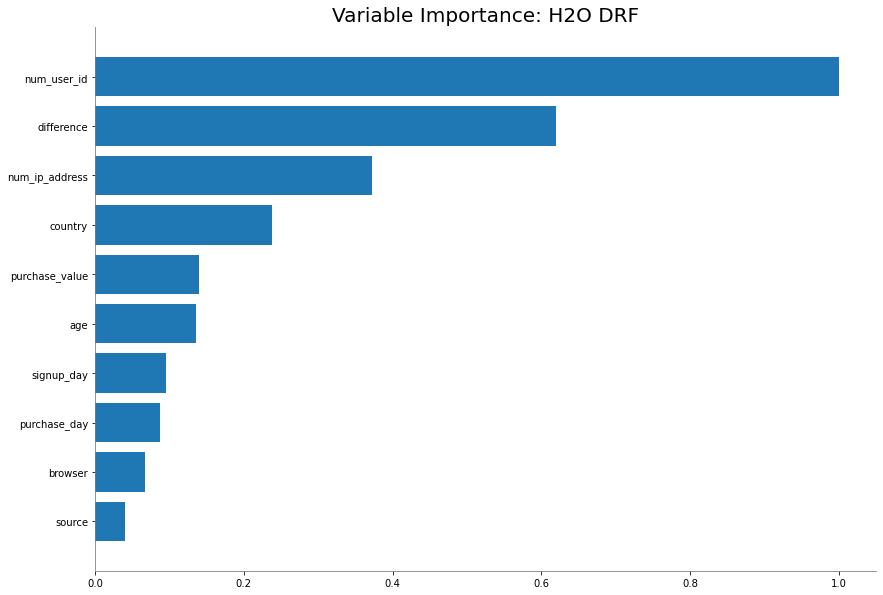

In [17]:
clf.varimp_plot()

In [27]:
# predict
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = clf.predict(train).as_data_frame()['p1'].values
test_pred = clf.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [23]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.54      0.70      4245

    accuracy                           0.96     45333
   macro avg       0.98      0.77      0.84     45333
weighted avg       0.96      0.96      0.95     45333



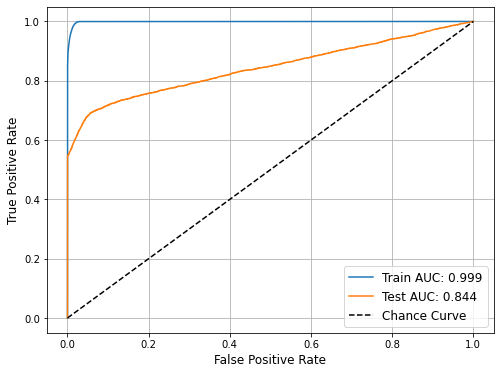

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


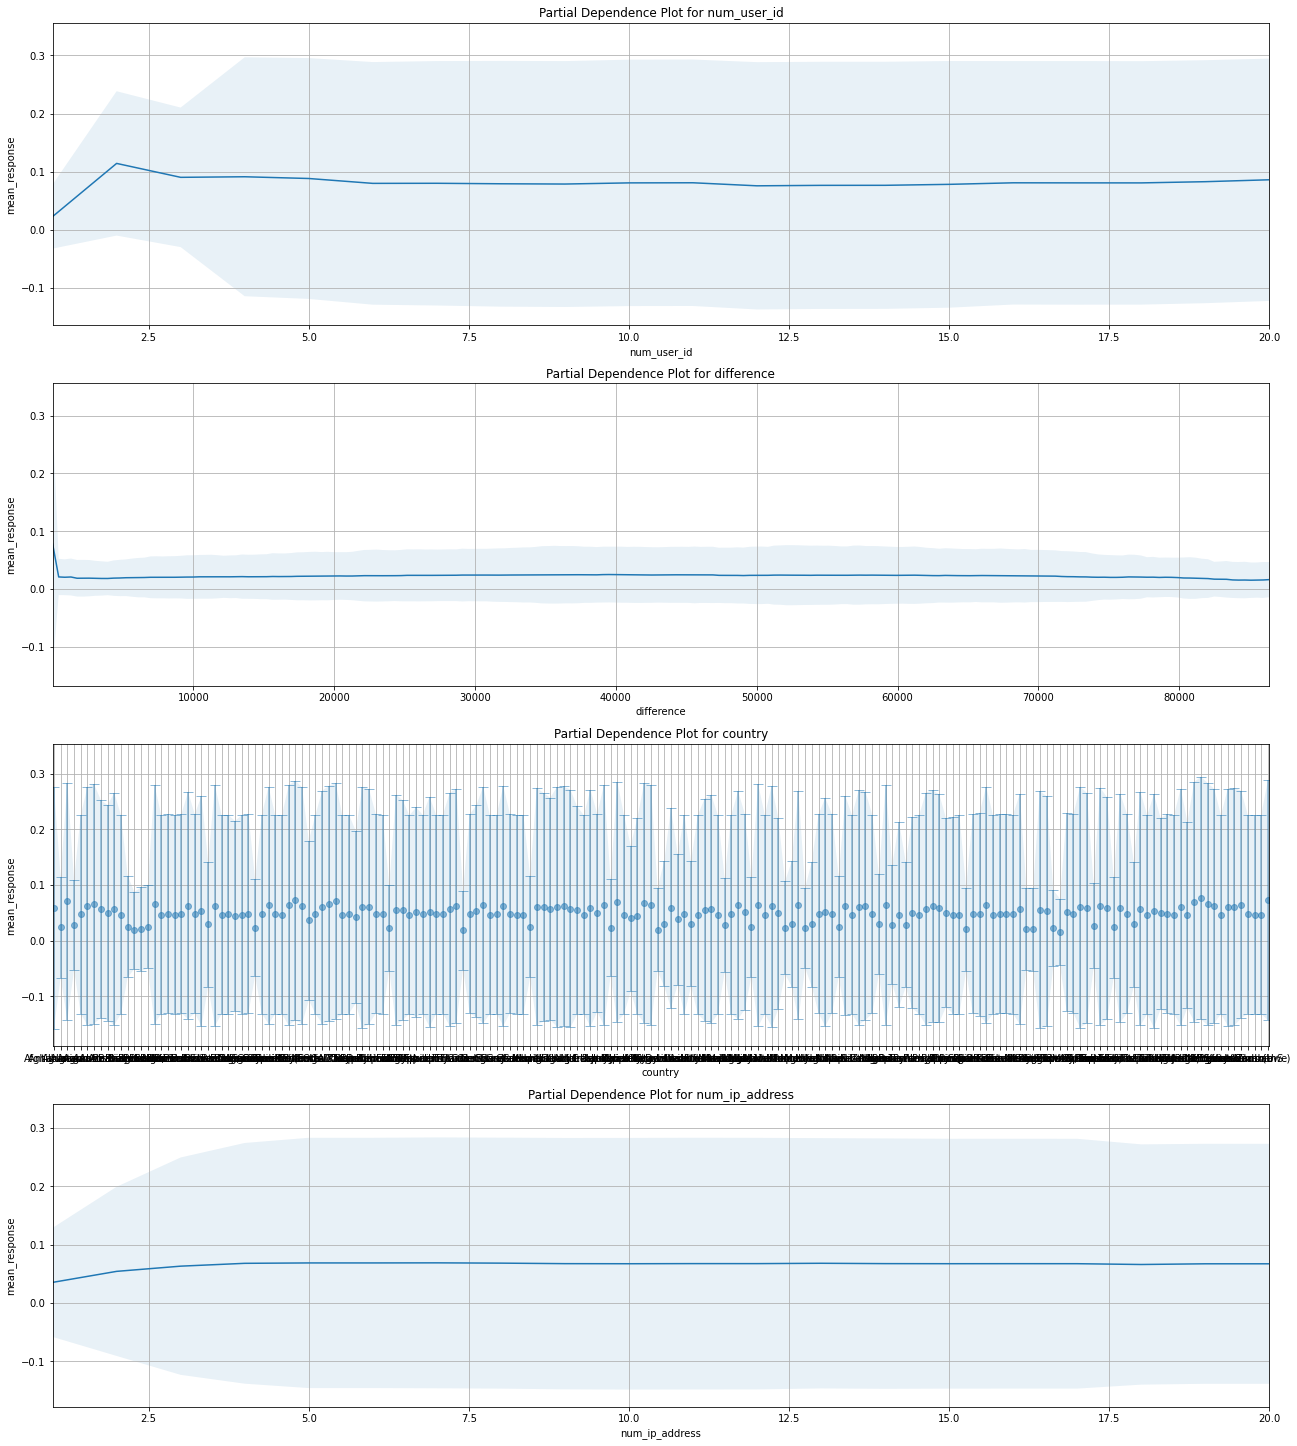

In [37]:
cols = ['num_user_id', 'difference', 'country', 'num_ip_address']
_ = clf.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [38]:
h2o.cluster().shutdown()

H2O session _sid_8c8e closed.
